Reference Dataset:
[IAM Dataset](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database)


# Get Data

!wget -q https://git.io/J0fjL -O IAM_Words.zip \
!unzip -qq IAM_Words.zip \
\
!mkdir data \
!mkdir data/words \
!tar -xf IAM_Words/words.tgz -C data/words \
!mv IAM_Words/words.txt data

In [15]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


# Setup

In [16]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

# Data Spliting

In [17]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")


Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823



## Data input pipeline

We start building our data input pipeline by first preparing the image paths.

In [18]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

"""
Then we prepare the ground-truth labels.
"""

# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [19]:
"""
Now we clean the validation and the test labels as well.
"""


def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [20]:
"""
### Building the character vocabulary

Keras provides different preprocessing layers to deal with different modalities of data.
[This guide](https://keras.io/guides/preprocessing_layers/) provides a comprehensive introduction.
Our example involves preprocessing labels at the character
level. This means that if there are two labels, e.g. "cat" and "dog", then our character
vocabulary should be {a, c, d, g, o, t} (without any special tokens). We use the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup/)
layer for this purpose.
"""


AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


In [21]:
"""
### Resizing images without distortion

Instead of square images, many OCR models work with rectangular images. This will become
clearer in a moment when we will visualize a few samples from the dataset. While
aspect-unaware resizing square images does not introduce a significant amount of
distortion this is not the case for rectangular images. But resizing images to a uniform
size is a requirement for mini-batching. So we need to perform our resizing such that
the following criteria are met:

* Aspect ratio is preserved.
* Content of the images is not affected.
"""


def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


If we just go with the plain resizing then the images would look like so:

![](https://i.imgur.com/eqq3s4N.png)

Notice how this resizing would have introduced unnecessary stretching.

In [22]:
"""
### Putting the utilities together
"""

batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)



In [23]:
"""
## Prepare `tf.data.Dataset` objects
"""

train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)


2022-09-07 12:27:13.092471: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


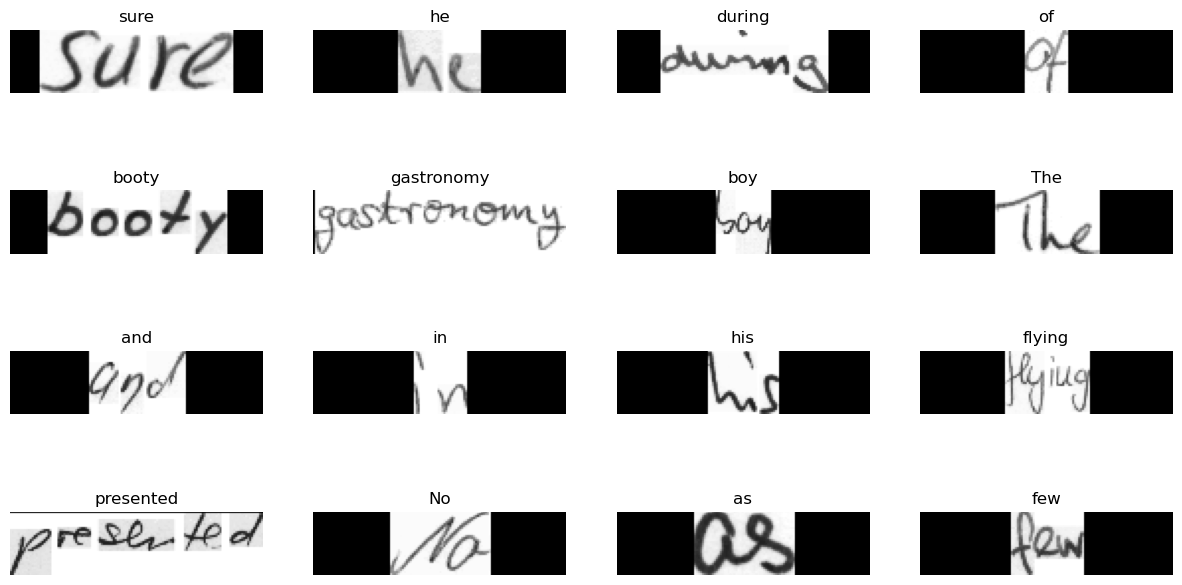

In [24]:
"""
## Visualize a few samples
"""

for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

## Model

Our model will use the CTC loss as an endpoint layer. For a detailed understanding of the
CTC loss, refer to [this post](https://distill.pub/2017/ctc/).

In [25]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

## Evaluation metric

[Edit Distance](https://en.wikipedia.org/wiki/Edit_distance)
is the most widely used metric for evaluating OCR models. In this section, we will
implement it and use it as a callback to monitor our model.

In [26]:
"""
We first segregate the validation images and their labels for convenience.
"""
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

"""
Now, we create a callback to monitor the edit distances.
"""


def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


## Training

Now we are ready to kick off model training.

In [29]:
epochs = 50  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/50


2022-09-07 12:48:21.151387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 12:48:21.828625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 12:48:21.842807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 12:48:22.067123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 12:48:22.083194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 12:48:22.533623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 12:48:22.548100: I tensorflow/core/grappler/optimizers/cust

1357/1357 [==============================] - ETA: 0s - loss: 13.3924

2022-09-07 13:00:31.811422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 13:00:32.028280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 13:00:32.035144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 13:00:32.114110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 13:00:32.120871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 13:00:57.447767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 13:00:57.568882: I tensorflow/core/grappler/optimizers/cust

2/2 [==============================] - 0s 24ms/step


2022-09-07 13:00:57.654994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 13:00:57.661049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 18ms/step


2022-09-07 13:01:02.775290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 13:01:02.911593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 13:01:02.917584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 737ms/step
Mean edit distance for epoch 1: 20.4660
1357/1357 [==============================] - 765s 561ms/step - loss: 13.3924 - val_loss: 11.5053
Epoch 2/50


2022-09-07 13:01:02.997258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 13:01:03.003221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 39ms/step
Mean edit distance for epoch 2: 20.0846
1357/1357 [==============================] - 594s 438ms/step - loss: 10.1383 - val_loss: 9.4665
Epoch 3/50
1/1 [==============================] - 0s 33ms/step
Mean edit distance for epoch 3: 19.6588
1357/1357 [==============================] - 524s 386ms/step - loss: 8.1525 - val_loss: 7.8202


Epoch 4/50
1/1 [==============================] - 0s 34ms/step
Mean edit distance for epoch 4: 18.9057
1357/1357 [==============================] - 515s 379ms/step - loss: 6.3042 - val_loss: 5.8138
Epoch 5/50
1/1 [==============================] - 0s 32ms/step
Mean edit distance for epoch 5: 18.3380
1357/1357 [==============================] - 518s 381ms/step - loss: 4.9611 - val_loss: 4.3764


Epoch 6/50
1/1 [==============================] - 0s 37ms/step
Mean edit distance for epoch 6: 18.1286
1357/1357 [==============================] - 712s 525ms/step - loss: 4.1816 - val_loss: 3.8451
Epoch 7/50
1/1 [==============================] - 0s 39ms/step
Mean edit distance for epoch 7: 18.0152
1357/1357 [==============================] - 727s 536ms/step - loss: 3.6676 - val_loss: 3.5844


Epoch 8/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 8: 17.9928
1357/1357 [==============================] - 691s 509ms/step - loss: 3.3037 - val_loss: 3.4795
Epoch 9/50
1/1 [==============================] - 0s 34ms/step
Mean edit distance for epoch 9: 17.9171
1357/1357 [==============================] - 707s 521ms/step - loss: 3.0169 - val_loss: 3.3491


Epoch 10/50
1/1 [==============================] - 0s 39ms/step
Mean edit distance for epoch 10: 17.8977
1357/1357 [==============================] - 704s 519ms/step - loss: 2.7936 - val_loss: 3.3756
Epoch 11/50
1/1 [==============================] - 0s 37ms/step
Mean edit distance for epoch 11: 17.7837
1357/1357 [==============================] - 703s 518ms/step - loss: 2.6058 - val_loss: 3.1658


Epoch 12/50
1/1 [==============================] - 0s 35ms/step
Mean edit distance for epoch 12: 17.6990
1357/1357 [==============================] - 684s 504ms/step - loss: 2.4452 - val_loss: 3.0519
Epoch 13/50
1/1 [==============================] - 0s 48ms/step
Mean edit distance for epoch 13: 17.6786
1357/1357 [==============================] - 635s 468ms/step - loss: 2.3014 - val_loss: 3.0978


Epoch 14/50
1/1 [==============================] - 0s 40ms/step
Mean edit distance for epoch 14: 17.6786
1357/1357 [==============================] - 703s 518ms/step - loss: 2.1743 - val_loss: 3.1063
Epoch 15/50
1/1 [==============================] - 0s 43ms/step
Mean edit distance for epoch 15: 17.7059
1357/1357 [==============================] - 773s 570ms/step - loss: 2.0722 - val_loss: 3.1057


Epoch 16/50
1/1 [==============================] - 0s 46ms/step
Mean edit distance for epoch 16: 17.6873
1357/1357 [==============================] - 714s 526ms/step - loss: 1.9761 - val_loss: 3.1244
Epoch 17/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 17: 17.7309
1357/1357 [==============================] - 715s 527ms/step - loss: 1.9059 - val_loss: 3.1646


Epoch 18/50
1/1 [==============================] - 0s 44ms/step
Mean edit distance for epoch 18: 17.8205
1357/1357 [==============================] - 781s 575ms/step - loss: 1.8195 - val_loss: 3.4889
Epoch 19/50
1/1 [==============================] - 0s 46ms/step
Mean edit distance for epoch 19: 17.7994
1357/1357 [==============================] - 682s 503ms/step - loss: 1.7374 - val_loss: 3.4187


Epoch 20/50
1/1 [==============================] - 0s 36ms/step
Mean edit distance for epoch 20: 17.7801
1357/1357 [==============================] - 546s 402ms/step - loss: 1.6522 - val_loss: 3.3943
Epoch 21/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 21: 17.7777
1357/1357 [==============================] - 615s 453ms/step - loss: 1.5901 - val_loss: 3.4001


Epoch 22/50
1/1 [==============================] - 0s 29ms/step
Mean edit distance for epoch 22: 17.6898
1357/1357 [==============================] - 681s 502ms/step - loss: 1.6389 - val_loss: 3.1466
Epoch 23/50
1/1 [==============================] - 0s 31ms/step
Mean edit distance for epoch 23: 17.6686
1357/1357 [==============================] - 534s 393ms/step - loss: 1.4968 - val_loss: 3.1735


Epoch 24/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 24: 17.6753
1357/1357 [==============================] - 534s 394ms/step - loss: 1.3981 - val_loss: 3.2552
Epoch 25/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 25: 17.6707
1357/1357 [==============================] - 530s 390ms/step - loss: 1.3610 - val_loss: 3.3400


Epoch 26/50
1/1 [==============================] - 0s 29ms/step
Mean edit distance for epoch 26: 17.6370
1357/1357 [==============================] - 530s 390ms/step - loss: 1.2916 - val_loss: 3.2837
Epoch 27/50
1/1 [==============================] - 0s 31ms/step
Mean edit distance for epoch 27: 17.6844
1357/1357 [==============================] - 532s 392ms/step - loss: 1.2333 - val_loss: 3.4764


Epoch 28/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 28: 17.7365
1357/1357 [==============================] - 530s 390ms/step - loss: 1.2187 - val_loss: 3.6787
Epoch 29/50
1/1 [==============================] - 0s 31ms/step
Mean edit distance for epoch 29: 17.7359
1357/1357 [==============================] - 564s 415ms/step - loss: 1.2352 - val_loss: 3.7696


Epoch 30/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 30: 17.7884
1357/1357 [==============================] - 530s 391ms/step - loss: 1.2050 - val_loss: 3.9553
Epoch 31/50
1/1 [==============================] - 0s 29ms/step
Mean edit distance for epoch 31: 17.8287
1357/1357 [==============================] - 532s 392ms/step - loss: 1.1503 - val_loss: 4.2206


Epoch 32/50
1/1 [==============================] - 0s 27ms/step
Mean edit distance for epoch 32: 17.8032
1357/1357 [==============================] - 530s 391ms/step - loss: 1.1421 - val_loss: 4.0185
Epoch 33/50
1/1 [==============================] - 0s 29ms/step
Mean edit distance for epoch 33: 17.7561
1357/1357 [==============================] - 529s 390ms/step - loss: 1.0795 - val_loss: 3.8881


Epoch 34/50
1/1 [==============================] - 0s 29ms/step
Mean edit distance for epoch 34: 17.6987
1357/1357 [==============================] - 535s 394ms/step - loss: 1.0832 - val_loss: 3.7464
Epoch 35/50
1/1 [==============================] - 0s 31ms/step
Mean edit distance for epoch 35: 17.6702
1357/1357 [==============================] - 530s 390ms/step - loss: 1.0134 - val_loss: 3.7061


Epoch 36/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 36: 17.6644
1357/1357 [==============================] - 535s 394ms/step - loss: 0.9852 - val_loss: 3.6866
Epoch 37/50
1/1 [==============================] - 0s 29ms/step
Mean edit distance for epoch 37: 17.6663
1357/1357 [==============================] - 533s 393ms/step - loss: 1.0365 - val_loss: 3.7044


Epoch 38/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 38: 17.6520
1357/1357 [==============================] - 532s 392ms/step - loss: 0.9469 - val_loss: 3.6929
Epoch 39/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 39: 17.6934
1357/1357 [==============================] - 531s 391ms/step - loss: 0.8849 - val_loss: 3.9173


Epoch 40/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 40: 17.6872
1357/1357 [==============================] - 532s 392ms/step - loss: 0.8758 - val_loss: 3.9693
Epoch 41/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 41: 17.6880
1357/1357 [==============================] - 532s 392ms/step - loss: 0.8645 - val_loss: 4.0121


Epoch 42/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 42: 17.7104
1357/1357 [==============================] - 530s 391ms/step - loss: 0.8598 - val_loss: 4.0942
Epoch 43/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 43: 17.6495
1357/1357 [==============================] - 536s 395ms/step - loss: 0.8535 - val_loss: 3.8776


Epoch 44/50
1/1 [==============================] - 0s 29ms/step
Mean edit distance for epoch 44: 17.6798
1357/1357 [==============================] - 529s 390ms/step - loss: 0.7986 - val_loss: 4.0598
Epoch 45/50
1/1 [==============================] - 0s 28ms/step
Mean edit distance for epoch 45: 17.6974
1357/1357 [==============================] - 530s 391ms/step - loss: 0.8390 - val_loss: 4.1958


Epoch 46/50
1/1 [==============================] - 0s 29ms/step
Mean edit distance for epoch 46: 17.6980
1357/1357 [==============================] - 534s 393ms/step - loss: 0.7763 - val_loss: 4.1601
Epoch 47/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 47: 17.6712
1357/1357 [==============================] - 528s 389ms/step - loss: 0.7448 - val_loss: 4.0968


Epoch 48/50
1/1 [==============================] - 0s 27ms/step
Mean edit distance for epoch 48: 17.6686
1357/1357 [==============================] - 530s 390ms/step - loss: 0.7738 - val_loss: 4.1116
Epoch 49/50
1/1 [==============================] - 0s 27ms/step
Mean edit distance for epoch 49: 17.6631
1357/1357 [==============================] - 540s 398ms/step - loss: 0.7456 - val_loss: 4.1399


Epoch 50/50
1/1 [==============================] - 0s 29ms/step
Mean edit distance for epoch 50: 17.6708
1357/1357 [==============================] - 533s 393ms/step - loss: 0.6942 - val_loss: 4.2395


## Inference

2/2 [==============================] - 0s 17ms/step


2022-09-07 21:01:54.204825: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


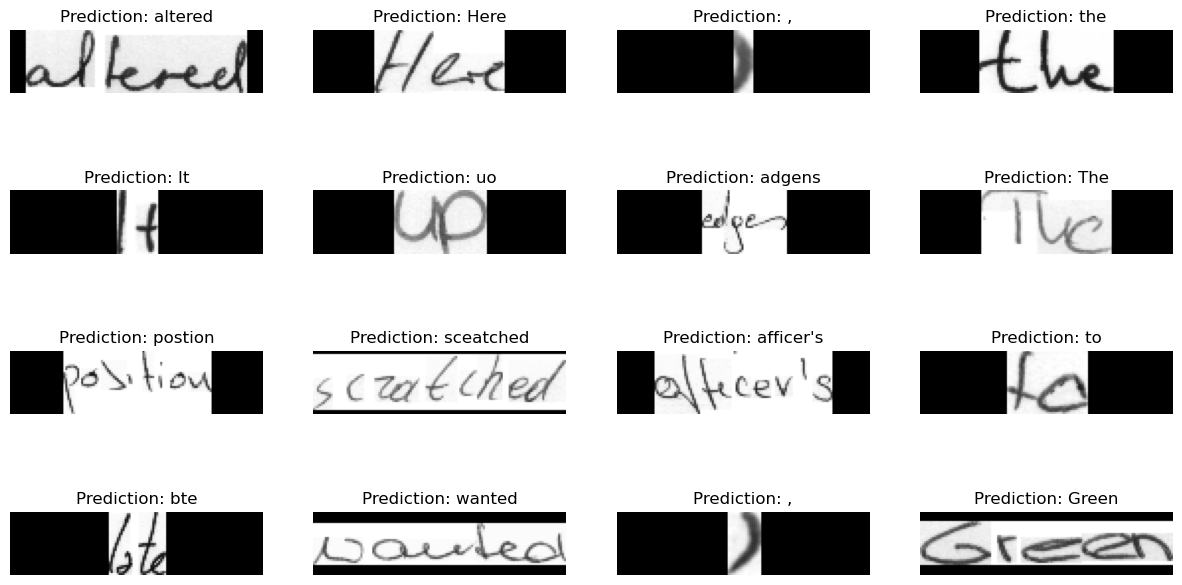

In [30]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

## Final remarks

* The `prediction_model` is fully compatible with TensorFlow Lite. If you are interested,
you can use it inside a mobile application. You may find
[this notebook](https://github.com/tulasiram58827/ocr_tflite/blob/main/colabs/captcha_ocr_tflite.ipynb)
to be useful in this regard.
* Not all the training examples are perfectly aligned as observed in this example. This
can hurt model performance for complex sequences. To this end, we can leverage
Spatial Transformer Networks ([Jaderberg et al.](https://arxiv.org/abs/1506.02025))
that can help the model learn affine transformations that maximize its performance.